In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../../code/')
import utils
import leakage
import scipy
import cobra

# Estimate release rates for B. licheniformisin glucose from Paczia et al. 2012

In [2]:
data_folder = Path('../../../data')
organism = 'b_licheniformis'
exometabolites_folder = data_folder / 'paczia_2012' /f"{organism}"
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)
supp_figure_folder = Path('../../../SupplementalFigures')


In [3]:
# Value from Goelzer et al., 2015 (https://doi.org/10.1016/j.ymben.2015.10.003)
# And also used in Massaiu et al., 2019 (https://doi.org/10.1186/s12934-018-1052-2)
gDW_per_OD = 0.48

In [4]:
concentrations, concentrations_std = leakage.get_concentrations(exometabolites_folder, organism)

In [5]:
df_OD = pd.read_csv(fn_OD, index_col=0)
df_OD.fillna(df_OD['OD std'].mean())

,OD mean,OD std
Time,,
0,1.700,0.000000
1,1.745,0.007071
2,1.905,0.063640
3,2.080,0.042426
4,3.095,0.120208
5,4.235,0.007071
6,6.940,0.197990
7,9.735,0.035355
8,15.110,1.230366


# Max growth rate

Growth rate: 0.3767837508664997


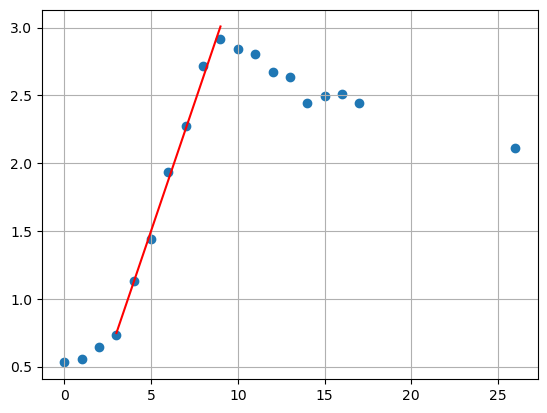

In [6]:
xarr = np.arange(3, 10, 1)
mu_fit = np.polyfit(df_OD.index[3:10], np.log(df_OD['OD mean'][3:10]), 1)
plt.scatter(df_OD.index, np.log(df_OD['OD mean']))
plt.plot(xarr, mu_fit[0]*xarr+mu_fit[1], c = 'r')
plt.grid()
print(f'Growth rate: {mu_fit[0]}')

# Estimate max glucose uptake rate


In [7]:
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

df_glucose = pd.read_csv(fn_glucose, index_col=0)
# df_glucose.loc[0,:]=[20,0] # From paper (in g/L)

In [8]:
cum_OD = np.zeros(19)*np.nan
for i in range(16):
    cum_OD[i+1] = scipy.integrate.simpson(df_OD.loc[1:i+1, 'OD mean'])

In [9]:
df_OD['Cum OD'] = cum_OD
df_OD['Cum OD gDW'] = df_OD['Cum OD']*gDW_per_OD
df_glucose['Glucose mM'] = df_glucose['Glucose mean']/180.18*1000

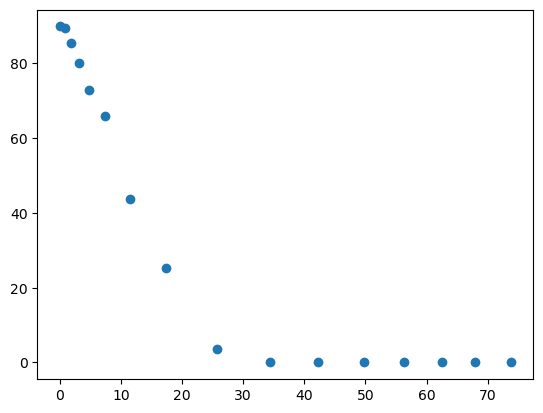

In [10]:
plt.scatter(df_OD['Cum OD gDW'], df_glucose['Glucose mM'])

In [11]:
fit = np.polyfit(df_OD.loc[1:9, 'Cum OD gDW'], df_glucose.loc[1:9, 'Glucose mM'], 1)
glucose_uptake = fit[0]
print(glucose_uptake)

-3.5450432070450515


## Mapping

In [12]:
mapping_df = pd.read_csv(data_folder / 'this_project/5_div/5B_id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Bacillus metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()
met_name_to_abrv = {value:key for key, value in met_abrv_to_name.items()}


# Estimate rates

## Simpson integration

In [13]:
xt = np.zeros(len(df_OD)-1)
for i in range(1, len(df_OD)-1):
    xt[i] = scipy.integrate.simpson(df_OD.loc[:i, 'OD mean'].values, x = df_OD.index[:i+1])
    # xt[i] = np.trapz(df_OD.loc[:i, 'OD mean'], dx=1)
    print(i, df_OD.loc[i, 'OD mean'], xt[i]*gDW_per_OD)

1 1.745 0.8268000000000001
2 1.905 1.6935999999999998
3 2.08 2.6494
4 3.095 3.8247999999999993
5 4.235 5.578999999999999
6 6.94 8.1408
7 9.735 12.139199999999999
8 15.11 17.8992
9 18.44 26.032999999999998
10 17.18 34.8672
11 16.57 42.9412
12 14.43 50.5296
13 13.97 57.278400000000005
14 11.52 63.622400000000006
15 12.13 69.176
16 12.27 75.192
17 11.54 80.9412


In [14]:
x = xt*gDW_per_OD

In [15]:
specific_limits = {
    'G6P': (1, 9),
    'F6P': (1, 9),
    'FBP': (2, 9),
    'DHAP': (1, 9),
    'GA3P': (1, 6),
    '23PG': (1, 9),
    'PEP': (1, 9),
    'R5P': (1, 9),
    'RU5P+X5P': (1, 9), 
    'E4P': (1, 9),
    'CIT': (1, 9),
    'ACN': (1, 9),
    'ICIT': (1, 9),
    'ASN': (2, 6),
    'GLU': (1, 6),
    'SER': (6, 7),
    'ASP': (1, 9),
    'GLN': (1, 6),
    'HOM': (1, 9),
    'TYR': (1, 9),
    'GLY': (1, 4),
    'PRO': (1, 6),
    'ALA': (1, 5),
    'MET': (1, 9),
    'VAL': (1, 9),
    'PHE': (1, 9),
    'LEU+ILEU': (1, 8),
    'TRP': (1, 9),
    'HIS': (1, 9),
    'LYS': (1, 9),
    'ARG': (1, 9),
    'PYR': (1, 8),
    'ORO': (1, 9),
    'FUM': (1, 8),
    'URA': (1, 9),
    'AKG': (1, 8),
    'SHI': (1, 9),
    'ACT': (1, 8),
}

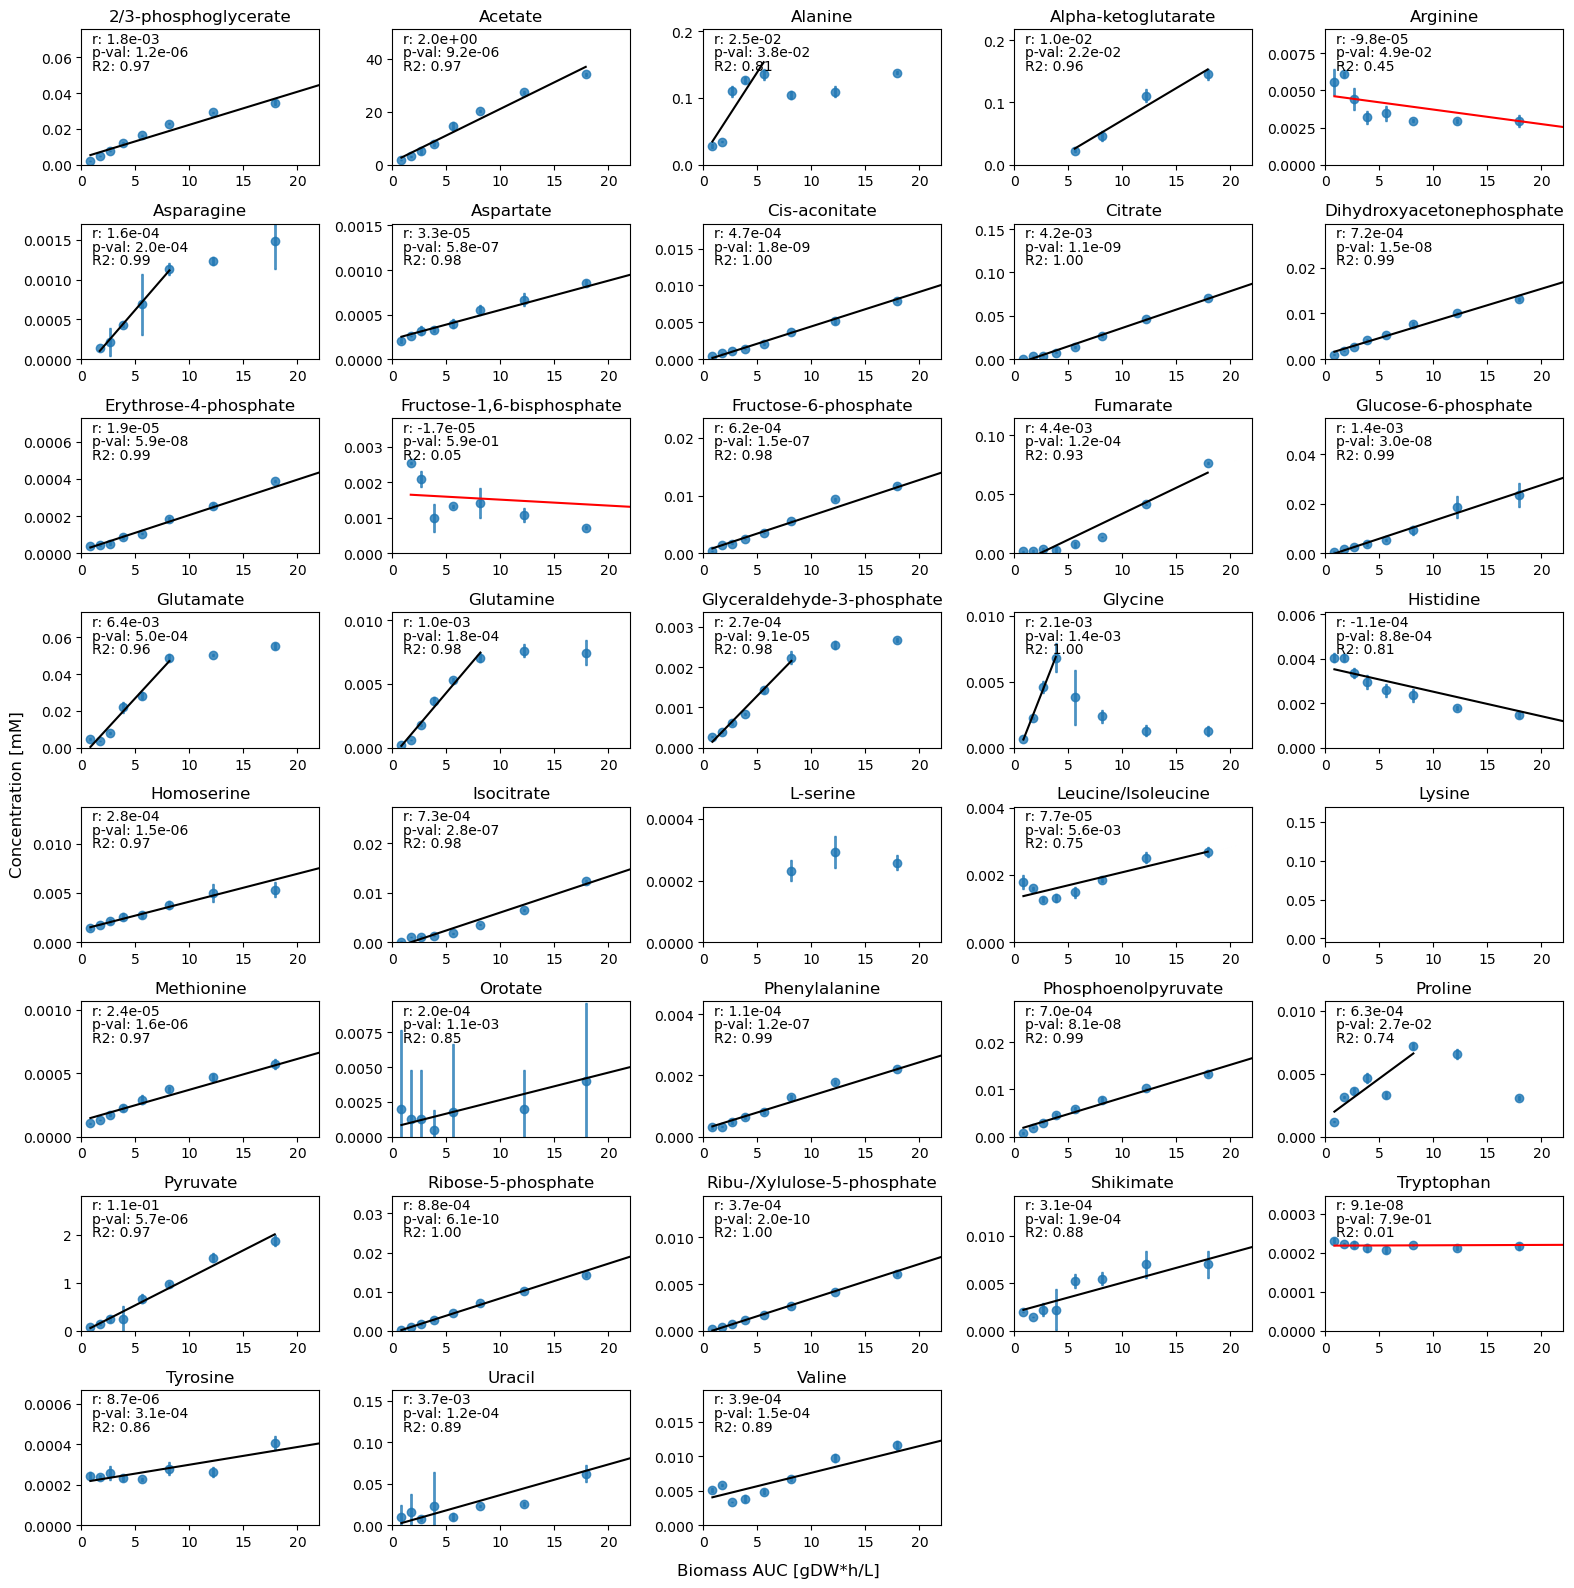

In [16]:
rate_dict_m = {}
fig, axes = plt.subplots(8,5, figsize = (16, 16), sharex = False)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
data_list = []
metabolite_names = sorted([met_abrv_to_name[c] for c in concentrations.columns])

for i,metabolite in enumerate(metabolite_names):
    c = met_name_to_abrv[metabolite]
    conc = concentrations[c][:-1]*1e-3 # Convert from uM to mM #
    conc_std = concentrations_std[c][:-1]*1e-3
    lim = specific_limits[c]
    conc[conc==0] = np.nan
    idx = ((concentrations.index >= lim[0]) & (concentrations.index <= lim[1]))[:-1] & np.isfinite(conc)
    rate_conc = conc[idx]
    
    ax = axes[i]
    ax.errorbar(x, conc, yerr = conc_std, fmt='o',color='C0',capthick=1,elinewidth=2,capsize=1, zorder = 0, alpha = 0.8)
    
    if len(rate_conc) >= 3:
        # conc[conc==0] = np.nan
        res = scipy.stats.linregress(x[idx], conc[idx])
        # print(f"R-squared: {res.rvalue**2:.6f}")
        r2 = res.rvalue**2
        data = [res.slope, res.stderr,res.pvalue, c, res.pvalue < 0.05, r2]
        x_fit = np.linspace(x[idx].min(), x[idx].max(), 3)
        y_fit = fun(x_fit, res.slope, res.intercept)
    
        if r2 > 0.5:
            ax.plot(x_fit, y_fit, 'k')
        else:
            ax.plot(x_fit, y_fit, 'r')
    else:
        data = [np.nan, np.nan, np.nan, c, np.nan, np.nan]

    data_list.append(data)


    ax.set_title(metabolite)
    ax.set_xlim(0, 22)
    y_max = np.max(conc[idx])*1.5
    if np.isfinite(y_max):
        ax.set_ylim(0, y_max)
    if len(rate_conc) >= 3:
        ax.annotate(f'r: {res.slope:.1e}', (1, y_max*0.9))
        ax.annotate(f'p-val: {res.pvalue:.1e}', (1, y_max*0.8))
        ax.annotate(f'R2: {r2:.2f}', (1, y_max*0.7))
    i +=1
    # print(i)

while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Biomass AUC [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.savefig(supp_figure_folder / 'blicheniformis_paczia_12_fitted_rates_manual_limits.png', dpi = 400)
plt.savefig(supp_figure_folder / 'blicheniformis_paczia_12_fitted_rates_manual_limits.pdf')
plt.show()

In [17]:
rate_data = pd.DataFrame(data_list, columns = ['Rate [mmol/gDW/h]', 'Std. Err [mmol/gDW/h]', 'p-val', 'Metabolite abbrv.', 'Significance', 'R2'])

# Get model

In [18]:
# Couldn't get this model to work with reframed 
model_fn = '../../../models/b_licheniformis/iBsu1147_irr_enz_constraint_adj.xml'
model_ez = cobra.io.read_sbml_model(model_fn)
# model = cobra.io.load_matlab_model('../../models/{0}/ec_iYO844.mat'.format(species))

model_ez.solver = 'gurobi'

Set parameter Username
Set parameter LicenseID to value 2586336
Academic license - for non-commercial use only - expires 2025-11-18


In [19]:
model_ez.reactions.EX_glc__D_e.lower_bound = glucose_uptake
solution = model_ez.optimize()

In [20]:
print(model_ez.summary())

Objective
1.0 bio00006 = 0.2656121579926823

Uptake
------
Metabolite    Reaction      Flux  C-Number  C-Flux
     ca2_e    EX_ca2_e 0.0007923         0   0.00%
     fe3_e    EX_fe3_e 0.0008523         0   0.00%
  glc__D_e EX_glc__D_e     3.545         6 100.00%
       k_e      EX_k_e    0.1747         0   0.00%
     mg2_e    EX_mg2_e   0.02516         0   0.00%
     nh4_e    EX_nh4_e     2.395         0   0.00%
      o2_e     EX_o2_e     10.15         0   0.00%
      pi_e     EX_pi_e    0.2711         0   0.00%
     so4_e    EX_so4_e   0.05263         0   0.00%
 prot_pool enzyme_pool     0.165         0   0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number  C-Flux
     co2_e EX_co2_e -10.81         1 100.00%
     h2o_e EX_h2o_e -16.76         0   0.00%
       h_e   EX_h_e -1.991         0   0.00%



In [21]:
measured_metabolites = []
for bigg_id in met_abrv_to_id.values():
    if not isinstance(bigg_id, str):
        continue
    m_ids = bigg_id.split(', ')
    for m_id in m_ids:
        if f'{m_id}_c' in model_ez.metabolites:
            measured_metabolites.append(f'{m_id}_c')

# Shadow prices

In [22]:
with model_ez as model:
    model.reactions.EX_glc__D_e.lower_bound = glucose_uptake
    shadow_prices = leakage.estimate_shadow_prices(model, delta=0.01, metabolites = measured_metabolites)

In [23]:
glc_uptake_range = np.linspace(glucose_uptake*1.2, glucose_uptake*0.8, 5, endpoint=True)

shadow_price_list = []
with model_ez as model:
    for g in glc_uptake_range:   
        model.reactions.EX_glc__D_e.lower_bound = g
    shadow_prices_i = leakage.estimate_shadow_prices(model, delta=0.01, metabolites = measured_metabolites)
    shadow_price_list.append(shadow_prices_i)
shadow_price_list.append(shadow_prices)

In [24]:
df_sp_var = pd.DataFrame(shadow_price_list)

# Turnover

In [25]:
with model_ez as model:
    model.reactions.EX_glc__D_e.lower_bound = glucose_uptake
    solution = cobra.flux_analysis.pfba(model)
turnover = {}
for m_id in measured_metabolites:
    m = model_ez.metabolites.get_by_id(m_id)
    turnover[m_id] = m.summary(solution).producing_flux['flux'].sum()

    

# Make spreadsheet

In [26]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The D-forms are used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std. Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if np.isnan(row['Rate [mmol/gDW/h]']):
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    if len(bigg_ids)>1:
        print(bigg_ids)
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std. Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name = met_abrv_to_name[abbr]
        m_id = f'{bigg_id}_c'
        mv = -shadow_prices[m_id]
        m = model_ez.metabolites.get_by_id(m_id)
        Nc = m.elements['C']
        mass = m.formula_weight
        mv_min = -df_sp_var.max()[m_id]
        mv_max = -df_sp_var.min()[m_id]
        data.append([abbr, bigg_id, name, mv, mv_min, mv_max, turnover[m_id], Nc, mass, rate_i, std_err_i, row['R2']])
df_rate = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'Model ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]','MV min', 'MV max', 
                                        'Turnover [mmol/gDW/h]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std. Err [mmol/gDW/h]', 'R2'])
        


['2pg', '3pg']
['leu__L', 'ile__L']
['ru5p__D', 'xu5p__D']


In [27]:
for idx, row in df_rate.iterrows():
    if row['Model ID'] == 'ile__L':
        print(df_rate.loc[idx, 'Metabolite'], f'Changed {idx} to Isoleucine')
        df_rate.loc[idx, 'Metabolite'] = 'Isoleucine'
        
    if row['Model ID'] == 'leu__L':
        print(df_rate.loc[idx, 'Metabolite'], f'Changed {idx} to Leucine')
        df_rate.loc[idx, 'Metabolite'] = 'Leucine'
    
    
    if row['Model ID'] == '2pg':
        print(df_rate.loc[idx, 'Metabolite'], f'Changed {idx} to 2-phosphoglycerate')
        df_rate.loc[idx, 'Metabolite'] = '2-phosphoglycerate'
        
    if row['Model ID'] == '3pg':
        print(df_rate.loc[idx, 'Metabolite'], f'Changed {idx} to 3-phosphoglycerate')
        df_rate.loc[idx, 'Metabolite'] = '3-phosphoglycerate'

    if row['Model ID'] == 'ru5p__D':
        print(df_rate.loc[idx, 'Metabolite'], f'Changed {idx} to Ribulose-5-phosphate')
        df_rate.loc[idx, 'Metabolite'] = 'Ribulose-5-phosphate'
        
    if row['Model ID'] == 'xu5p__D':
        print(df_rate.loc[idx, 'Metabolite'], f'Changed {idx} to Xylulose-5-phosphate')
        df_rate.loc[idx, 'Metabolite'] = 'Xylulose-5-phosphate'

        # print(row, f'Changed {idx} to Xylulose-5-phosphate')

2/3-phosphoglycerate Changed 0 to 2-phosphoglycerate
2/3-phosphoglycerate Changed 1 to 3-phosphoglycerate
Leucine/Isoleucine Changed 23 to Leucine
Leucine/Isoleucine Changed 24 to Isoleucine
Ribu-/Xylulose-5-phosphate Changed 32 to Ribulose-5-phosphate
Ribu-/Xylulose-5-phosphate Changed 33 to Xylulose-5-phosphate


In [28]:
df_rate['Species'] = 'B. licheniformis'
df_rate['Carbon source'] = 'Glucose'
df_rate['Dataset'] = 'Paczia-13'

In [29]:
df_rate.to_csv(data_folder / 'paczia_2012' / 'paczia_12_rates_blicheniformis.csv')

# No enzyme constraint

In [30]:
model0 = model_ez.copy()

Read LP format model from file /var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/tmpisw_nfm_.lp
Reading time = 0.01 seconds
: 1460 rows, 6592 columns, 32868 nonzeros


In [31]:
model0.reactions.enzyme_pool.upper_bound = 1000

In [32]:
model0.optimize()
print(model0.summary())

Objective
1.0 bio00006 = 0.27437378863467826

Uptake
------
Metabolite    Reaction      Flux  C-Number  C-Flux
     ca2_e    EX_ca2_e 0.0008185         0   0.00%
     fe3_e    EX_fe3_e 0.0008805         0   0.00%
  glc__D_e EX_glc__D_e     3.545         6 100.00%
       k_e      EX_k_e    0.1804         0   0.00%
     mg2_e    EX_mg2_e   0.02599         0   0.00%
     nh4_e    EX_nh4_e     2.474         0   0.00%
      o2_e     EX_o2_e     9.779         0   0.00%
      pi_e     EX_pi_e    0.2801         0   0.00%
     so4_e    EX_so4_e   0.05437         0   0.00%
 prot_pool enzyme_pool    0.2527         0   0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number  C-Flux
     co2_e EX_co2_e -10.46         1 100.00%
     h2o_e EX_h2o_e -16.61         0   0.00%
       h_e   EX_h_e -2.056         0   0.00%



In [33]:
with model0 as model:
    model.reactions.EX_glc__D_e.lower_bound = -5.3
    shadow_prices0 = leakage.estimate_shadow_prices(model, delta=0.01, metabolites = measured_metabolites)

## Make spreadsheet

In [34]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The D-forms are used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std. Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if row['R2']<0.5:
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    if len(bigg_ids)>1:
        print(bigg_ids)
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std. Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'{bigg_id}_c'
        mv = -shadow_prices0[m_id]
        m = model_ez.metabolites.get_by_id(m_id)
        Nc = m.elements['C']
        mass = m.formula_weight
        
        data.append([abbr, bigg_id, name, mv, Nc, mass, rate_i, std_err_i, row['R2']])
df_rate0 = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'Model ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std. Err [mmol/gDW/h]', 'R2'])

['2pg', '3pg']
['leu__L', 'ile__L']
['ru5p__D', 'xu5p__D']


In [35]:
df_rate0['Species'] = 'B. licheniformis'
df_rate0['Carbon source'] = 'Glucose'
df_rate0['Dataset'] = 'Paczia-13'
df_rate0.to_csv('paczia_13_rates_blicheniformis_0824_no_enz.csv')